In [11]:
%load_ext autoreload
%autoreload 2

import discord
import requests
import numpy as np
from tqdm import tqdm
from sympy import Symbol
from pathlib import Path
import centrex_TlF as centrex
import matplotlib.pyplot as plt

import ctypes
from multiprocessing import Process, Array

import sys
sys.path.append("../..")
from utils.plot_utils import set_fontsize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
nprocs_python = 6 # processes for python
nprocs_julia = 7 # processes for julia

# Γ
Γ = 1.56e6*2*np.pi

# TlF temperature
T = 6.3

# Define all involved states

# ground state J levels
ground_Js = [0,1,2,3]

# excited state quantum numbers
excited_Js = [1]
excited_F1s = [3/2]
excited_Fs= [1]
excited_Ps = [-1]

# Settings for transitions

# min and max J level to look for mixing in the B state
excited_Jmin = 1
excited_Jmax = 4


# main laser transition R(1) F'=3 F1'=5/2

ground_main_approx = 1*centrex.CoupledBasisState(J=2,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', 
                                         P = (-1)**2, Omega = 0)
excited_main_approx = 1*centrex.CoupledBasisState(J=1,
                                          F1=3/2,
                                          F=1,
                                          mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
# ground laser J
laser_J = [2]

transitions = [{'ground main approx': ground_main_approx, 
                'excited main approx': excited_main_approx,
                'ground states approx': 1*centrex.states.generate_coupled_states_ground(laser_J),
                'excited states approx': 1*centrex.states.generate_coupled_states_excited(
                                                excited_Js, excited_Fs, excited_F1s, excited_Ps),
                'main polarization': np.array([0,0,1]),
                'polarizations': [np.array([0,0,1]), np.array([1,0,0])],
                'polarization symbols': [Symbol("Plz"), Symbol("Plx")],
                'Ω symbol': Symbol('Ωl', complex = True),
                'Δ symbol': Symbol('δl'),
                'description': "laser transition"
               }]

# make sure that subsequent transitions don't have their excited state be the ground state of another transition
transitions.append(
    {
        'ground main approx': 1*centrex.CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**2, Omega = 0),
        'excited main approx': 1*centrex.CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0),
        'ground states approx': 1*centrex.states.generate_coupled_states_ground([2]),
        'excited states approx': 1*centrex.states.generate_coupled_states_ground([1]),
        'main polarization': np.array([0,0,1]),
        'polarizations': [np.array([0,0,1]), np.array([0,1,0])],
        'polarization symbols': [Symbol("Pμ12z"), Symbol("Pμ12y")],
        'Ω symbol': Symbol('Ωμ12', complex = True),
        'Δ symbol': Symbol('δμ12'),
        'description': "J12 microwave transition"
    }
)

transitions.append(
    {
        'ground main approx': 1*centrex.CoupledBasisState(J=2,F1=5/2,F=2,mF=0,I1=1/2,I2=1/2, electronic_state='X', P = (-1)**2, Omega = 0),
        'excited main approx': 1*centrex.CoupledBasisState(J=3,F1=5/2,F=3,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = (-1)**1, Omega = 0),
        'ground states approx': 1*centrex.states.generate_coupled_states_ground([2]),
        'excited states approx': 1*centrex.states.generate_coupled_states_ground([3]),
        'main polarization': np.array([0,0,1]),
        'polarizations': [np.array([0,0,1]), np.array([0,1,0])],
        'polarization symbols': [Symbol("Pμ23z"), Symbol("Pμ23y")],
        'Ω symbol': Symbol('Ωμ23', complex = True),
        'Δ symbol': Symbol('δμ23'),
        'description': "J23 microwave transition"
    }
)

# sanity check to ensure no ground states for one transition are an
# excited state for another transition
centrex.couplings.utils.check_transitions(transitions)

In [13]:
slice_compact = None

In [14]:
# progress bar stuff
fname_counter = "counter.txt"
webhook_url = "https://discord.com/api/webhooks/879110452364341279/qeSWCjvrd973S17_Qf7csPHjoaw4y0AO3BU0v8baWJ3LssW5uCl29XyleQXfxQaP6EYm"

### Specifying parameters and the ode function preamble
Allows for setting parameters to be time dependent (e.g. sin(t), cos(t))

In [15]:
# order of parameters in p
parameters = ['Ωl', 'δl', 'ωp', 'ϕp', 'y0', 'vy', 'vz', 'σylaser', 'σzlaser', 'β', 'ωphase',
              'Ωμ12', 'δμ12', 'ωpμ12', 'ϕpμ12', 'Ωμ23', 'δμ23', 'ωpμ23', 'ϕpμ23', 'μzμ', 'σyμ', 'σzμ',
              'mp_passes', 'mp_amps', 'mp_locs']

In [16]:
preamble = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = complex(p[1])
\t\tδl = p[2]
\t\tωp = p[3]
\t\tϕp = p[4]
\t\ty0 = p[5]
\t\tvy = p[6]
\t\tvz = p[7]
\t\tσylaser = p[8]
\t\tσzlaser = p[9]
\t\tβ = p[10]
\t\tωphase = p[11]
\t\tΩμ12 = complex(p[12])
\t\tδμ12 = p[13]
\t\tωpμ12 = p[14]
\t\tϕpμ12 = p[15]
\t\tΩμ23 = complex(p[16])
\t\tδμ23 = p[17]
\t\tωpμ23 = p[18]
\t\tϕpμ23 = p[19]
\t\tμzμ = p[20]
\t\tσyμ = p[21]
\t\tσzμ = p[22]
\t\tmp_passes = floor(Int8,p[23])
\t\tmp_amps::Array{Float64,1} = p[24:24+mp_passes-1]
\t\tmp_locs::Array{Float64,1} = p[24+mp_passes:end]

\t\tΩl = Ωl .* multipass_2d_intensity(vz*t, y0+vy*t, mp_amps, mp_locs, σzlaser, σylaser) .* phase_modulation(t, β, ωphase)
\t\tΩlᶜ = conj(Ωl)

\t\tΩμ12 = Ωμ12 .* gaussian_2d(vz*t, y0+vy*t, 1., μzμ, 0., σzμ, σyμ)
\t\tΩμ12ᶜ = conj(Ωμ12)

\t\tΩμ23 = Ωμ23 .* gaussian_2d(vz*t, y0+vy*t, 1., μzμ, 0., σzμ, σyμ)
\t\tΩμ23ᶜ = conj(Ωμ23)

\t\tPl = sin(ωp*t + ϕp)
\t\tPlx = (1-Pl)/2
\t\tPlz = (1+Pl)/2

\t\tPμ12z = square_wave(t, ωpμ12, ϕpμ12)
\t\tPμ12y = square_wave(t, ωpμ12, ϕpμ12+π)

\t\tPμ23z = square_wave(t, ωpμ23, ϕpμ23)
\t\tPμ23y = square_wave(t, ωpμ23, ϕpμ23+π)
"""

In [17]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = Γ
odepars.ωp = Γ
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, ωp: 9.80e+06, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 0.00e+00, σylaser: 0.00e+00, σzlaser: 0.00e+00, β: 0.00e+00, ωphase: 0.00e+00, Ωμ12: 0.00e+00, δμ12: 0.00e+00, ωpμ12: 0.00e+00, ϕpμ12: 0.00e+00, Ωμ23: 0.00e+00, δμ23: 0.00e+00, ωpμ23: 0.00e+00, ϕpμ23: 0.00e+00, μzμ: 0.00e+00, σyμ: 0.00e+00, σzμ: 0.00e+00, mp_passes: 0.00e+00, mp_amps: 0.00e+00, mp_locs: 0.00e+00)

## Start calculations for Hamiltonian and transitions

In [18]:
%%time 
ground_states_approx = centrex.states.generate_coupled_states_ground(ground_Js)
excited_states_approx = centrex.states.generate_coupled_states_excited(excited_Js, excited_Fs, 
                                                                       excited_F1s, excited_Ps)

ground_states, excited_states, QN, H_int, V_ref_int = centrex.hamiltonian.generate_total_reduced_hamiltonian(
                                            ground_states_approx, excited_states_approx)

Wall time: 10.5 s


In [19]:
%%time
couplings = []
for transition in transitions:
    coupling = centrex.couplings.generate_coupling_field(
                                        transition['ground main approx'],
                                        transition['excited main approx'],
                                        transition['ground states approx'],
                                        transition['excited states approx'],
                                        H_int, QN, V_ref_int, 
                                        pol_main = transition['main polarization'],
                                        pol_vec = transition['polarizations'],
                                        nprocs = nprocs_python)
    couplings.append(coupling)

Wall time: 7min 6s


In [20]:
%%time
H_symbolic = centrex.lindblad.generate_total_symbolic_hamiltonian(QN, H_int, couplings, transitions, 
                                                                slice_compact = slice_compact)

Wall time: 2.03 s


In [21]:
# still something going wrong with rotating frame approximation, manually adjust
slice_J1 = centrex.utils.J_slice(1)
slice_J2 = centrex.utils.J_slice(2)
slice_J3 = centrex.utils.J_slice(3)

idx_J2 = [s.find_largest_component() for s in QN].index(transitions[1]['ground main approx'].find_largest_component())
val = H_symbolic[idx_J2, idx_J2]
for idx in range(slice_J2.start, slice_J2.stop):
    H_symbolic[idx, idx] -= val

idx_J1 = [s.find_largest_component() for s in QN].index(transitions[1]['excited main approx'].find_largest_component())
val = H_symbolic[idx_J1, idx_J1]
val = [v for v in val.atoms() if v.is_number]
if len(val) >0:
    val = val[0]
    for idx in range(slice_J1.start, slice_J1.stop):
        H_symbolic[idx, idx] -= val
        
idx_J3 = [s.find_largest_component() for s in QN].index(transitions[2]['excited main approx'].find_largest_component())
val = H_symbolic[idx_J3, idx_J3]
val = [v for v in val.atoms() if v.is_number]
if len(val) >0:
    val = val[0]
    for idx in range(slice_J3.start, slice_J3.stop):
        H_symbolic[idx, idx] -= val
    
idx_B = [s.find_largest_component() for s in QN].index(transitions[0]['excited main approx'].find_largest_component())
val = H_symbolic[idx_B, idx_B]
val = [v for v in val.atoms() if v.is_number][0]
for idx in [idx for idx, s in enumerate(QN) if s.find_largest_component().electronic_state == 'B']:
    H_symbolic[idx, idx] -= val

In [22]:
%%time
C_array = centrex.couplings.collapse_matrices(QN, ground_states, excited_states, gamma = Γ, 
                                            slice_compact = slice_compact)
system = centrex.lindblad.generate_system_of_equations_symbolic(H_symbolic, C_array, progress = False, fast = True)

Wall time: 1min 44s


In [23]:
%%time
# convert matrix to system of equations code
code_lines = centrex.lindblad.system_of_equations_to_lines(system, nprocs = nprocs_python)

Wall time: 2min 2s


# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [14]:
# import julia
# julia.install()

In [24]:
from julia import Main
centrex.lindblad.initialize_julia(nprocs = nprocs_julia)

_ = centrex.lindblad.generate_ode_fun_julia(preamble, code_lines)

# generate initial conditions
ρ_ini = centrex.utils.generate_thermal_J([0,1,2,3],3,6.3)
centrex.lindblad.setup_variables_julia(Γ, ρ_ini)
odepars.generate_p_julia()

Initialized Julia with 7 processes


In [25]:
Main.eval("""
using BenchmarkTools
@everywhere using Waveforms

@everywhere function gaussian_2d(x::Float64, y::Float64, a::Float64, μx::Float64, μy::Float64, σx::Float64, σy::Float64)::Float64
    a*exp(-((x-μx)^2 / (2 * σx*σx) + (y-μy)^2 / (2 * σy*σy)))
end

@everywhere function phase_modulation(t::Float64, β::Float64, ω::Float64)::ComplexF64
    return exp(1im*β*sin(ω*t))
end

@everywhere function multipass_2d_intensity(x::Float64, y::Float64, amplitudes::Vector{Float64}, locations::Vector{Float64}, σx::Float64, σy::Float64)::Float64
    intensity::Float64 = 0.0
    for i = 1:length(amplitudes::Vector{Float64})
        @inbounds intensity += gaussian_2d(x,y,amplitudes[i],locations[i],0.0, σx,σy)
    end
    return intensity
end

@everywhere function square_wave(t, ω, ϕ)
    0.5.*(1 .+ squarewave(ω.*t .+ ϕ))
end

const channel = RemoteChannel(()->Channel{Int}(10000))
@everywhere const channel = $channel

""")

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [26]:
def multipass_prism_order(passes):
    npass = [1]
    for p in range(1,passes):
        if p%2 == 0:
            npass.append(p+1)
        else:
            npass.append(passes-p)
    return npass

nr_passes = 15
beam_spacing = (1.75*25.4*1e-3)/nr_passes
beam_locs = np.array([i*beam_spacing for i in range(nr_passes)]) + 0.005

reflections = (np.array(multipass_prism_order(15))-1)
loss = 0.17 # reflection loss per pass
amplitudes = np.array([(1-loss)**r for r in reflections])

In [27]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.ωp = 0
odepars.σylaser = 2*5265*1e-6/4
odepars.σzlaser = 2642*1e-6/4
odepars.y0 = 0
odepars.vz = 184
odepars.vy = 0
odepars.β = 3.8
odepars.ωphase = 2*np.pi*1.6e6
odepars.μzμ = beam_locs.mean()
odepars.σzμ = 25.4e-3/2.355
odepars.σyμ = 25.4e-3/2.355

odepars.ωpμ12 = 2*np.pi*1e6
odepars.ωpμ23 = 2*np.pi*1e6
setattr(odepars, dir(odepars)[-1], np.pi/2)

odepars.mp_passes = 15
odepars.mp_amps = amplitudes
odepars.mp_locs = beam_locs

In [28]:
Ωl = centrex.utils.calculate_rabi_from_power_gaussian_beam(80e-3, 
                                                           np.abs(couplings[0]['main coupling'].real),
                                                           σx = odepars.σzlaser, σy = odepars.σylaser)
Ωμ12 = centrex.utils.calculate_rabi_from_power_gaussian_beam_microwave(300e-3, 
                                                                       np.abs(couplings[1]['main coupling'].real),
                                                                       σx = odepars.σzμ, σy = odepars.σyμ
                                                                       )
Ωμ23 = centrex.utils.calculate_rabi_from_power_gaussian_beam_microwave(300e-3, 
                                                                       np.abs(couplings[2]['main coupling'].real),
                                                                       σx = odepars.σzμ, σy = odepars.σyμ
                                                                       )
odepars.Ωl = Ωl
odepars.Ωμ12 = Ωμ12
odepars.Ωμ23 = Ωμ23
odepars.generate_p_julia()
print(odepars.to_units_Γ(Γ))

odeParameters(Ωl: 0.62, δl: 0.00, ωp: 0.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, σylaser: 2.63e-03, σzlaser: 6.60e-04, β: 3.80e+00, ωphase: 1.03, Ωμ12: 3.74, δμ12: 0.00, ωpμ12: 0.64, ϕpμ12: 0.00e+00, Ωμ23: 0.27, δμ23: 0.00, ωpμ23: 0.64, ϕpμ23: 1.57e+00, μzμ: 2.57e-02, σyμ: 1.08e-02, σzμ: 1.08e-02, mp_passes: 1.50e+01, mp_amps: [1.         0.08871871 0.6889     0.12878314 0.47458321 0.18694026
 0.32694037 0.27136051 0.22522922 0.39390406 0.15516041 0.571787
 0.10689001 0.83       0.07363653], mp_locs: [0.005      0.00796333 0.01092667 0.01389    0.01685333 0.01981667
 0.02278    0.02574333 0.02870667 0.03167    0.03463333 0.03759667
 0.04056    0.04352333 0.04648667])


In [29]:
%%time
Main.du = np.zeros(ρ_ini.shape, dtype = complex)
Main.eval("""
@everywhere p = $p
@everywhere du = $du
@everywhere @time Lindblad_rhs!(du, ρ, p, 0.0);
""");

Wall time: 16min 54s


In [30]:
%%time
Main.eval(f"""
tspan = (0.0, {(4*odepars.σzlaser + odepars.mp_locs[-1])  / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
tmp = 0
""");

Wall time: 468 ms


0

In [31]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 32.1 s


0

In [32]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

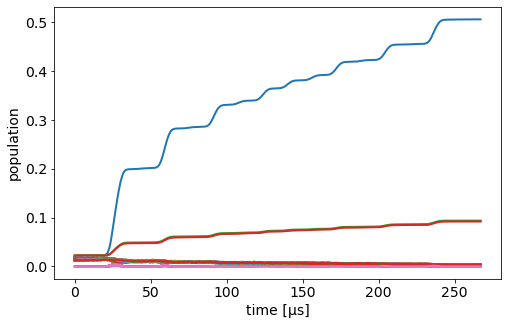

In [33]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(0,len(pop_results)):
        s = QN[idx].find_largest_component()
        if s.F is None:
            label = f'{s.electronic_state}, J={s.J}'
        else:
            label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [34]:
pop_results[0,:][-1]/pop_results[0,:][0]

22.656706244934412

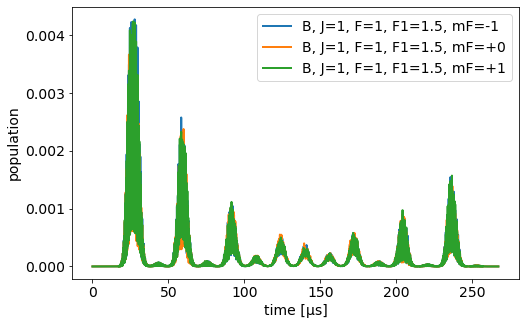

In [35]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx >= H_symbolic.shape[0] - len(excited_states):
        s = QN[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [36]:
_ = pop_results[centrex.utils.J_slice(0),[0,-1]].sum(axis = 0)
print(f"{_[-1]/_[0]:.2f}")

8.78


In [37]:
_ = pop_results[centrex.utils.J_slice(1),[0,-1]].sum(axis = 0)
print(f"{100*_[-1]/_[0]:.2f} %")

17.59 %


In [38]:
_ = pop_results[centrex.utils.J_slice(2),[0,-1]].sum(axis = 0)
print(f"{100*_[-1]/_[0]:.2f} %")

21.61 %


In [39]:
_ = pop_results[centrex.utils.J_slice(3),[0,-1]].sum(axis = 0)
print(f"{100*_[-1]/_[0]:.2f} %")

30.09 %


## Trajectory simulations

In [40]:
data_dir = Path('.').absolute()
fname = 'trajectories.npy'
_, y0s, _, vxs, vys, vzs = np.load(data_dir / fname)

In [41]:
# new y0 positions 1" in front of LIF laser
in_to_m = 25.4e-3
distance_laser_rc = 21.75 * in_to_m - 0.01
distance_laser_lif = 38.30 * in_to_m - 0.01
y0s_start = (distance_laser_rc - 1*in_to_m)/vzs * vys + y0s

# 1 m/s equals 2.32 Γ detuning
δls = vxs * 2.32 * Γ

In [42]:
params = np.stack([δls, y0s_start, vys, vzs])
Main.params = params
Main.eval("@everywhere params = $params")

In [43]:
Main.eval("""
@everywhere condition(u,t,integrator) = integrator.p[7]*t > 0.05
@everywhere affect!(integrator) = terminate!(
integrator)
cb = DiscreteCallback(condition, affect!)
""");

In [44]:
odepars.generate_p_julia()
print(odepars.to_units_Γ(Γ))
Main.eval("@everywhere p = $p");

odeParameters(Ωl: 0.62, δl: 0.00, ωp: 0.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, σylaser: 2.63e-03, σzlaser: 6.60e-04, β: 3.80e+00, ωphase: 1.03, Ωμ12: 3.74, δμ12: 0.00, ωpμ12: 0.64, ϕpμ12: 0.00e+00, Ωμ23: 0.27, δμ23: 0.00, ωpμ23: 0.64, ϕpμ23: 1.57e+00, μzμ: 2.57e-02, σyμ: 1.08e-02, σzμ: 1.08e-02, mp_passes: 1.50e+01, mp_amps: [1.         0.08871871 0.6889     0.12878314 0.47458321 0.18694026
 0.32694037 0.27136051 0.22522922 0.39390406 0.15516041 0.571787
 0.10689001 0.83       0.07363653], mp_locs: [0.005      0.00796333 0.01092667 0.01389    0.01685333 0.01981667
 0.02278    0.02574333 0.02870667 0.03167    0.03463333 0.03759667
 0.04056    0.04352333 0.04648667])


In [45]:
Main.eval(f"""
@everywhere function prob_func_prerc(prob,i,repeat)
    remake(prob,p=[{odepars.Ωl}; params[1,i]; {odepars.ωp}; 0; params[2,i]; params[3,i];
                    params[4,i]; {odepars.σylaser}; {odepars.σzlaser}; {odepars.β};
                    {odepars.ωphase};
                    {odepars.Ωμ12}; {odepars.δμ12}; {odepars.ωpμ12}; {getattr(odepars, dir(odepars)[-2])};
                    {odepars.Ωμ23}; {odepars.δμ23}; {odepars.ωpμ23}; {getattr(odepars, dir(odepars)[-1])};
                    {odepars.μzμ}; {odepars.σyμ}; {odepars.σzμ}; {odepars.mp_passes}; p[24:end]])
end
""")

In [46]:
Main.eval("""
@everywhere function output_func(sol,i)
    put!(channel, 1)
    return real(diag(sol.u[end])), false
end
""")

# setup progress bar
Main.n_trajectories = params.shape[-1]
Main.eval(f"""
using ProgressMeter
progress = Progress(n_trajectories, showspeed = true)
""");

In [47]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);
""");

In [48]:
Main.eval(f"""
open("{fname_counter}", "w") do io
    print(io, 0)
end
""")

In [49]:
from discord_progress import start_ensemble_with_progressbar

In [50]:
%%time 
start_ensemble_with_progressbar(Main.n_trajectories, f'RC P2 F1 {loss*100:.1f}% loss', webhook_url, fname_counter, "ens_prob",
                                save_everystep = False)

Wall time: 3h 31min 38s


In [51]:
results = np.array(Main.eval("sim.u"))
gain_F0 = results[:,0]/np.diag(ρ_ini.real)[0]

18.67716085899591


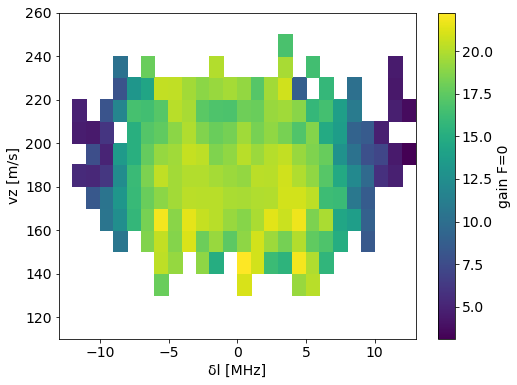

In [52]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = gain_F0
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('gain F=0')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

print(np.mean(gain_F0))

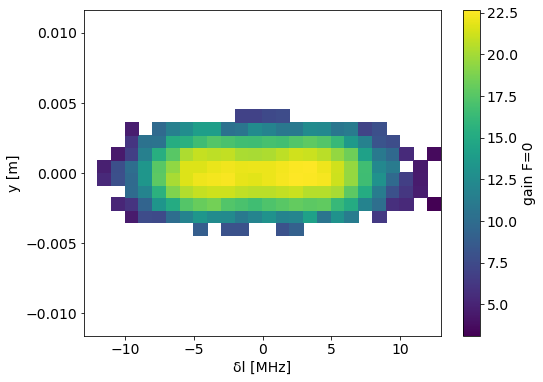

In [53]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(y0s.min(), y0s.max(),27)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[1,:]
z = gain_F0
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'y [m]')
cbar.ax.set_ylabel('gain F=0')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

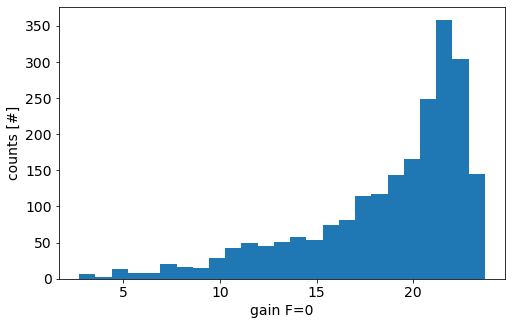

In [54]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(gain_F0, bins = 25);
ax.set_xlabel("gain F=0")
ax.set_ylabel('counts [#]')
set_fontsize(ax, 14)

In [55]:
results_array = []
for i in range(params.shape[1]):
    i += 1
    _ = Main.eval(f"""
        [{odepars.Ωl}; params[1,{i}]; {odepars.ωp}; 0; params[2,{i}]; params[3,{i}];
        params[4,{i}]; {odepars.σylaser}; {odepars.σzlaser}; {odepars.β}; {odepars.ωphase};
        {odepars.Ωμ12}; {odepars.δμ12}; {odepars.ωpμ12}; {getattr(odepars, dir(odepars)[-2])};
        {odepars.Ωμ23}; {odepars.δμ23}; {odepars.ωpμ23}; {getattr(odepars, dir(odepars)[-1])};
        {odepars.μzμ}; {odepars.σyμ}; {odepars.σzμ}; {odepars.mp_passes}; p[24:end]]
    """)
    _ = np.append(_, results[i-1])
    results_array.append(_)
results_array = np.asarray(results_array)

In [56]:
fname_results = "P2F1_RC_cooling_17pc_mploss"
np.save(fname_results, results_array)

## 10% loss per pass

In [57]:
reflections = (np.array(multipass_prism_order(15))-1)
loss = 0.1 # reflection loss per pass
amplitudes = np.array([(1-loss)**r for r in reflections])

In [61]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.ωp = 0
odepars.σylaser = 2*5265*1e-6/4
odepars.σzlaser = 2642*1e-6/4
odepars.y0 = 0
odepars.vz = 184
odepars.vy = 0
odepars.β = 3.8
odepars.ωphase = 2*np.pi*1.6e6
odepars.μzμ = beam_locs.mean()
odepars.σzμ = 25.4e-3/2.355
odepars.σyμ = 25.4e-3/2.355

odepars.ωpμ12 = 2*np.pi*1e6
odepars.ωpμ23 = 2*np.pi*1e6
setattr(odepars, dir(odepars)[-1], np.pi/2)

odepars.mp_passes = 15
odepars.mp_amps = amplitudes
odepars.mp_locs = beam_locs

Ωl = centrex.utils.calculate_rabi_from_power_gaussian_beam(80e-3, 
                                                           np.abs(couplings[0]['main coupling'].real),
                                                           σx = odepars.σzlaser, σy = odepars.σylaser)
Ωμ12 = centrex.utils.calculate_rabi_from_power_gaussian_beam_microwave(300e-3, 
                                                                       np.abs(couplings[1]['main coupling'].real),
                                                                       σx = odepars.σzμ, σy = odepars.σyμ
                                                                       )
Ωμ23 = centrex.utils.calculate_rabi_from_power_gaussian_beam_microwave(300e-3, 
                                                                       np.abs(couplings[2]['main coupling'].real),
                                                                       σx = odepars.σzμ, σy = odepars.σyμ
                                                                       )
odepars.Ωl = Ωl
odepars.Ωμ12 = Ωμ12
odepars.Ωμ23 = Ωμ23

In [62]:
odepars.generate_p_julia()
print(odepars.to_units_Γ(Γ))
Main.eval("@everywhere p = $p")

odeParameters(Ωl: 0.62, δl: 0.00, ωp: 0.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, σylaser: 2.63e-03, σzlaser: 6.60e-04, β: 3.80e+00, ωphase: 1.03, Ωμ12: 3.74, δμ12: 0.00, ωpμ12: 0.64, ϕpμ12: 0.00e+00, Ωμ23: 0.27, δμ23: 0.00, ωpμ23: 0.64, ϕpμ23: 1.57e+00, μzμ: 2.57e-02, σyμ: 1.08e-02, σzμ: 1.08e-02, mp_passes: 1.50e+01, mp_amps: [1.         0.25418658 0.81       0.3138106  0.6561     0.38742049
 0.531441   0.4782969  0.43046721 0.59049    0.34867844 0.729
 0.28242954 0.9        0.22876792], mp_locs: [0.005      0.00796333 0.01092667 0.01389    0.01685333 0.01981667
 0.02278    0.02574333 0.02870667 0.03167    0.03463333 0.03759667
 0.04056    0.04352333 0.04648667])


In [63]:
# setup progress bar
Main.eval(f"""
progress = Progress(n_trajectories, showspeed = true)
ens_prob = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);

open("{fname_counter}", "w") do io
    print(io, 0)
end
""");

In [64]:
%%time 
start_ensemble_with_progressbar(Main.n_trajectories, f'RC P2 F1 {loss*100:.1f}% loss', webhook_url, fname_counter, "ens_prob",
                                save_everystep = False)

Wall time: 3h 14min 3s


In [65]:
results = np.array(Main.eval("sim.u"))
gain_F0 = results[:,0]/np.diag(ρ_ini.real)[0]

23.09303227897933


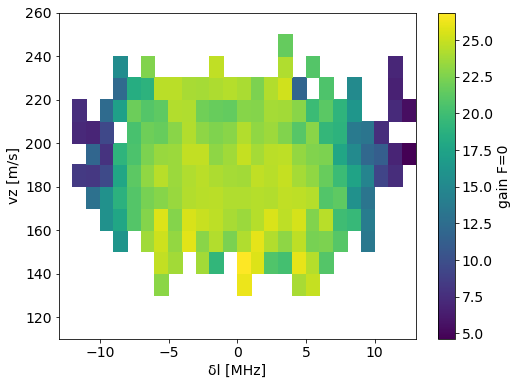

In [66]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = gain_F0
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('gain F=0')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

print(np.mean(gain_F0))

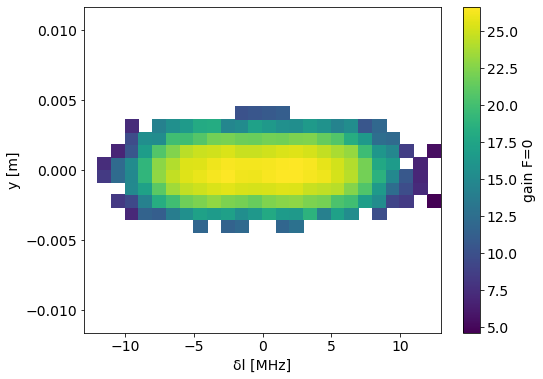

In [67]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(y0s.min(), y0s.max(),27)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[1,:]
z = gain_F0
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'y [m]')
cbar.ax.set_ylabel('gain F=0')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

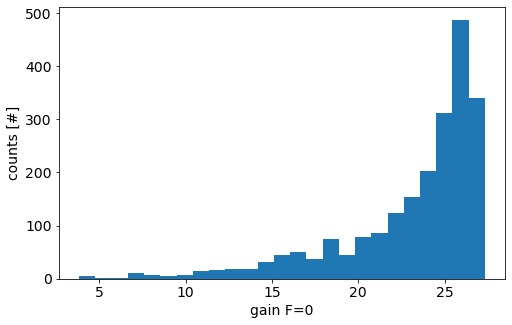

In [68]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(gain_F0, bins = 25);
ax.set_xlabel("gain F=0")
ax.set_ylabel('counts [#]')
set_fontsize(ax, 14)

In [69]:
results_array = []
for i in range(params.shape[1]):
    i += 1
    _ = Main.eval(f"""
        [{odepars.Ωl}; params[1,{i}]; {odepars.ωp}; 0; params[2,{i}]; params[3,{i}];
        params[4,{i}]; {odepars.σylaser}; {odepars.σzlaser}; {odepars.β}; {odepars.ωphase};
        {odepars.Ωμ12}; {odepars.δμ12}; {odepars.ωpμ12}; {getattr(odepars, dir(odepars)[-2])};
        {odepars.Ωμ23}; {odepars.δμ23}; {odepars.ωpμ23}; {getattr(odepars, dir(odepars)[-1])};
        {odepars.μzμ}; {odepars.σyμ}; {odepars.σzμ}; {odepars.mp_passes}; p[24:end]]
    """)
    _ = np.append(_, results[i-1])
    results_array.append(_)
results_array = np.asarray(results_array)

In [70]:
fname_results = "P2F1_RC_cooling_10pc_mploss"
np.save(fname_results, results_array)

## Try multiple losses

12.0% loss per pass -> 21.75
14.0% loss per pass -> 20.46
16.0% loss per pass -> 19.25


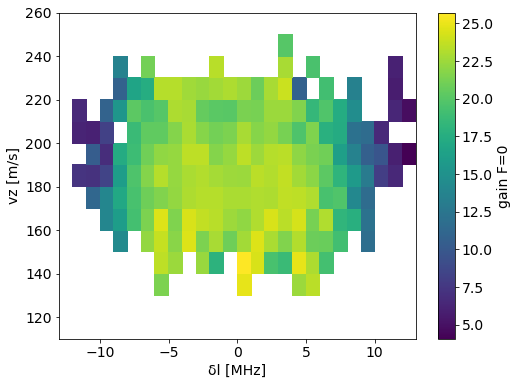

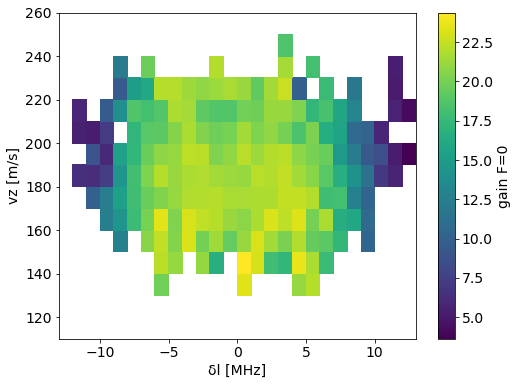

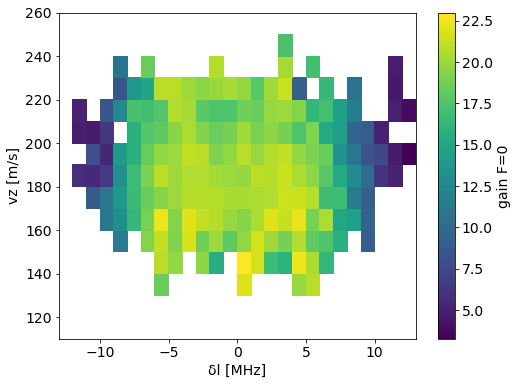

In [82]:
# loss per pass
for loss in np.arange(0.12, 0.18, 0.02):
    reflections = (np.array(multipass_prism_order(15))-1)
    amplitudes = np.array([(1-loss)**r for r in reflections])
    
    odepars.mp_amps = amplitudes
    
    odepars.generate_p_julia()
    Main.eval("@everywhere p = $p")
    
    Main.eval(f"""
    ens_prob = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);

    open("{fname_counter}", "w") do io
        print(io, 0)
    end
    """);
    
    start_ensemble_with_progressbar(Main.n_trajectories, f'RC P2 F1 {loss*100:.1f}% loss status', webhook_url, fname_counter, "ens_prob",
                                    save_everystep = False)
    
    
    results = np.array(Main.eval("sim.u"))
    gain_F0 = results[:,0]/np.diag(ρ_ini.real)[0]
    
    xbins = np.linspace(-13, 13, 27)
    ybins = np.linspace(110, 260, 16)

    x = params[0,:]/Γ * 1.6
    y = params[3,:]
    z = gain_F0
    stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
    X, Y = np.meshgrid(x_edge,y_edge)

    fig, ax = plt.subplots(figsize = (8,6))
    cs = ax.pcolormesh(X, Y, stat.T)

    cbar = fig.colorbar(cs)


    ax.set_xlabel('δl [MHz]')
    ax.set_ylabel(r'vz [m/s]')
    cbar.ax.set_ylabel('gain F=0')
    set_fontsize(ax, 14)
    set_fontsize(cbar.ax, 14)

    print(f"{loss*100:.1f}% loss per pass -> {np.mean(gain_F0):.2f}")
    
    results_array = []
    for i in range(params.shape[1]):
        i += 1
        _ = Main.eval(f"""
            [{odepars.Ωl}; params[1,{i}]; {odepars.ωp}; 0; params[2,{i}]; params[3,{i}];
            params[4,{i}]; {odepars.σylaser}; {odepars.σzlaser}; {odepars.β}; {odepars.ωphase};
            {odepars.Ωμ12}; {odepars.δμ12}; {odepars.ωpμ12}; {getattr(odepars, dir(odepars)[-2])};
            {odepars.Ωμ23}; {odepars.δμ23}; {odepars.ωpμ23}; {getattr(odepars, dir(odepars)[-1])};
            {odepars.μzμ}; {odepars.σyμ}; {odepars.σzμ}; {odepars.mp_passes}; p[24:end]]
        """)
        _ = np.append(_, results[i-1])
        results_array.append(_)
    results_array = np.asarray(results_array)
    
    fname_results = f"P2F1_RC_cooling_{np.ceil(loss*100):.0f}pc_mploss"
    np.save(fname_results, results_array)

In [93]:
for fn in [f'P2F1_RC_cooling_{i}pc_mploss.npy' for i in [10,12,14,16,17]]:
    values = np.load(fn)
    F0 = values[:,-67:][:,0]
    F1 = values[:,-67:][:,1:4].sum(axis = 1)
    F01 = values[:,-67:][:,:4].sum(axis = 1)
    
    gF0 = F0.mean()/np.diag(ρ_ini.real)[0]
    gF1 = F1.mean()/np.diag(ρ_ini.real)[1:4].sum()
    gF01 = F01.mean()/np.diag(ρ_ini.real)[:4].sum()
    pc = int(fn.split('_')[3].strip('pc'))
    print(f"F=0 gain for {pc}% loss/pass -> {gF0:.2f}")
    print(f"F=1 gain for {pc}% loss/pass -> {gF1:.2f}")
    print(f'R0 F1 gain for {pc}% loss/pass -> {gF01:.2f}')
    print("="*50)

F=0 gain for 10% loss/pass -> 23.09
F=1 gain for 10% loss/pass -> 4.22
R0 F1 gain for 10% loss/pass -> 8.94
F=0 gain for 12% loss/pass -> 21.75
F=1 gain for 12% loss/pass -> 4.03
R0 F1 gain for 12% loss/pass -> 8.46
F=0 gain for 14% loss/pass -> 20.46
F=1 gain for 14% loss/pass -> 3.84
R0 F1 gain for 14% loss/pass -> 7.99
F=0 gain for 16% loss/pass -> 19.25
F=1 gain for 16% loss/pass -> 3.66
R0 F1 gain for 16% loss/pass -> 7.56
F=0 gain for 17% loss/pass -> 18.68
F=1 gain for 17% loss/pass -> 3.58
R0 F1 gain for 17% loss/pass -> 7.35


## Laser Power Scan

In [102]:
Ωls = [centrex.utils.calculate_rabi_from_power_gaussian_beam(Ωli, 
                                                           np.abs(couplings[0]['main coupling'].real),
                                                           σx = odepars.σzlaser, σy = odepars.σylaser)
       for Ωli in [200e-3, 300e-3, 400e-3, 500e-3]]

loss = 0.14
reflections = (np.array(multipass_prism_order(15))-1)
amplitudes = np.array([(1-loss)**r for r in reflections])

odepars.mp_amps = amplitudes

In [117]:
Main.n_trajectories = 2173

200 mW -> 25.72
300 mW -> 27.12
400 mW -> 27.82
500 mW -> 28.22


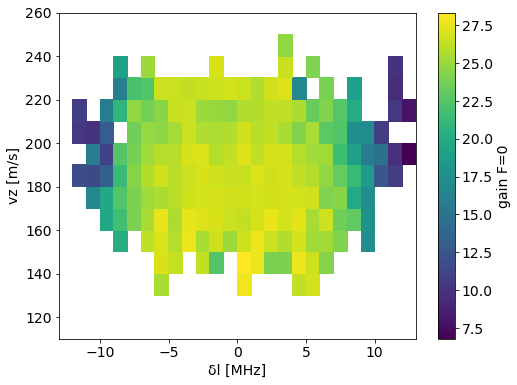

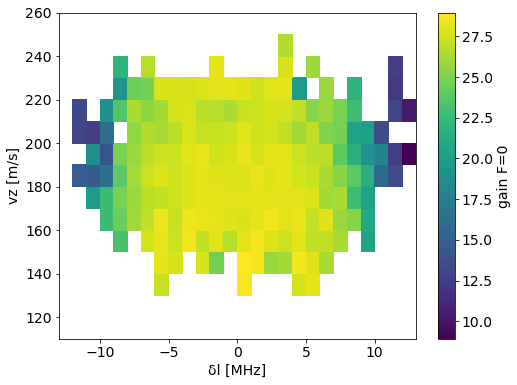

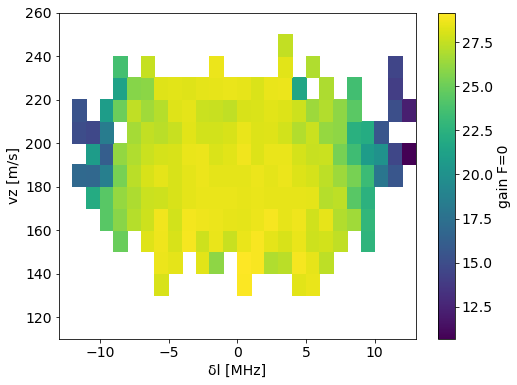

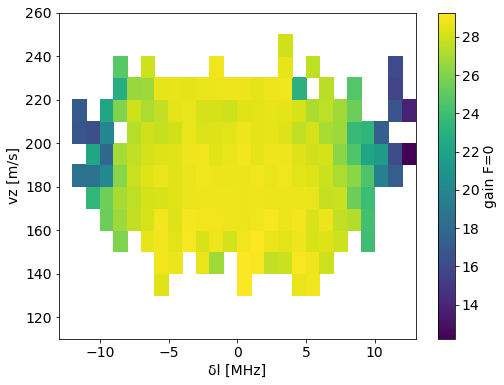

In [118]:
# laser power
for Ωli in Ωls:
    odepars.Ωl = Ωli
    odepars.generate_p_julia()
    Main.eval("@everywhere p = $p")
    
    lpower = centrex.utils.calculate_power_from_rabi_gaussian_beam(Ωli, 
                                                           np.abs(couplings[0]['main coupling'].real),
                                                           σx = odepars.σzlaser, σy = odepars.σylaser)

    Main.eval(f"""
    @everywhere function prob_func_prerc(prob,i,repeat)
        remake(prob,p=[{odepars.Ωl}; params[1,i]; {odepars.ωp}; 0; params[2,i]; params[3,i];
                        params[4,i]; {odepars.σylaser}; {odepars.σzlaser}; {odepars.β};
                        {odepars.ωphase};
                        {odepars.Ωμ12}; {odepars.δμ12}; {odepars.ωpμ12}; {getattr(odepars, dir(odepars)[-2])};
                        {odepars.Ωμ23}; {odepars.δμ23}; {odepars.ωpμ23}; {getattr(odepars, dir(odepars)[-1])};
                        {odepars.μzμ}; {odepars.σyμ}; {odepars.σzμ}; {odepars.mp_passes}; p[24:end]])
    end
    """)
    
    Main.eval(f"""
    ens_prob = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);

    open("{fname_counter}", "w") do io
        print(io, 0)
    end
    """);
    
    start_ensemble_with_progressbar(Main.n_trajectories, f'RC P2 F1 {lpower*1e3:.0f} mW status', webhook_url, fname_counter, "ens_prob",
                                    save_everystep = False)
    
    
    results = np.array(Main.eval("sim.u"))
    gain_F0 = results[:,0]/np.diag(ρ_ini.real)[0]
    
    xbins = np.linspace(-13, 13, 27)
    ybins = np.linspace(110, 260, 16)

    x = params[0,:][:Main.n_trajectories]/Γ * 1.6
    y = params[3,:][:Main.n_trajectories]
    z = gain_F0
    stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
    X, Y = np.meshgrid(x_edge,y_edge)

    fig, ax = plt.subplots(figsize = (8,6))
    cs = ax.pcolormesh(X, Y, stat.T)

    cbar = fig.colorbar(cs)


    ax.set_xlabel('δl [MHz]')
    ax.set_ylabel(r'vz [m/s]')
    cbar.ax.set_ylabel('gain F=0')
    set_fontsize(ax, 14)
    set_fontsize(cbar.ax, 14)
    

    print(f"{lpower*1e3:.0f} mW -> {np.mean(gain_F0):.2f}")
    
    results_array = []
    for i in range(params.shape[1])[:Main.n_trajectories]:
        i += 1
        _ = Main.eval(f"""
            [{odepars.Ωl}; params[1,{i}]; {odepars.ωp}; 0; params[2,{i}]; params[3,{i}];
            params[4,{i}]; {odepars.σylaser}; {odepars.σzlaser}; {odepars.β}; {odepars.ωphase};
            {odepars.Ωμ12}; {odepars.δμ12}; {odepars.ωpμ12}; {getattr(odepars, dir(odepars)[-2])};
            {odepars.Ωμ23}; {odepars.δμ23}; {odepars.ωpμ23}; {getattr(odepars, dir(odepars)[-1])};
            {odepars.μzμ}; {odepars.σyμ}; {odepars.σzμ}; {odepars.mp_passes}; p[24:end]]
        """)
        _ = np.append(_, results[i-1])
        results_array.append(_)
    results_array = np.asarray(results_array)
    
    fname_results = f"P2F1_RC_cooling_{lpower*1e3:.0f}mW_lpower"
    np.save(fname_results, results_array)